In [610]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import utils
from PIL import Image
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from google.colab import drive
import os, sys

In [611]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + K.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + K.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

# Preprocessing data

In [612]:
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Garbage in, garbage out/data/'
%cd /content/drive/MyDrive/Garbage\ in,\ garbage out/data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Garbage in, garbage out/data


### Preparing and encoding images

In [613]:
def resize_image(src_img, size, bg_color): 
    src_img.thumbnail(size, Image.ANTIALIAS) 
    new_image = Image.new("RGB", size, bg_color)
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
    return new_image

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

In [614]:
X, y = [], []
size = (128,128)
background_color="white"
test_image_files = os.listdir(folder_path) 

for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(folder_path, test_image_files[file_idx])).convert('RGB')
    resized_img = np.array(resize_image(img, size, background_color)) 
    cropped_img = np.array(crop_max_square(img).resize((size[0], size[1]), Image.LANCZOS)) 
    X.append(cropped_img) 
    y.append(test_image_files[file_idx][0]) 

X, y = np.asarray(X), np.reshape(np.asarray(y), (len(y), 1))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (675, 128, 128, 3) 
y shape: (675, 1)


### Splitting and visualization

In [615]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

print('X_train shape:', X_train.shape, '\ny_train shape:', y_train.shape, 
      '\nX_test shape:', X_test.shape, '\ny_test shape:', y_test.shape)

X_train shape: (540, 128, 128, 3) 
y_train shape: (540, 1) 
X_test shape: (135, 128, 128, 3) 
y_test shape: (135, 1)


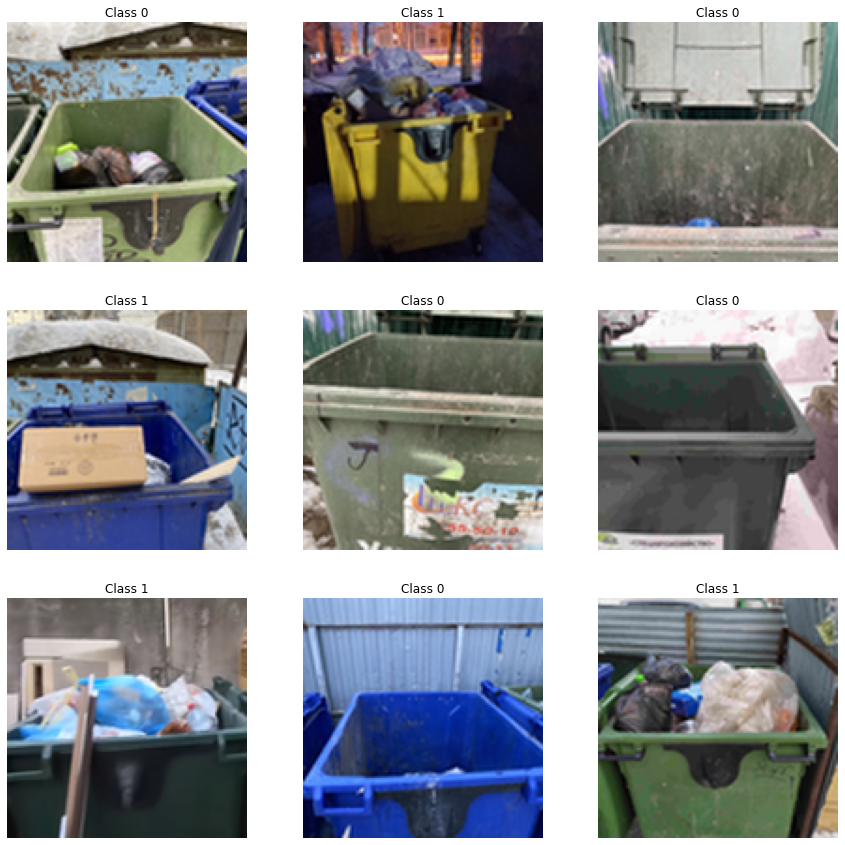

In [616]:
ax = []
fig = plt.figure(figsize=(15,15))

for i in range(9):
    ax.append(fig.add_subplot(3, 3, i+1)) 
    plt.imshow(X_train[i])
    plt.title(str('Class ' + y_train[i][0]))
    plt.axis('off')

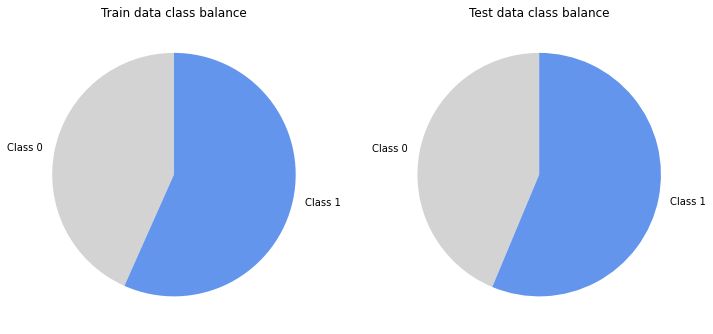

In [617]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
plt.title('Train data class balance')
ax1.pie(np.unique(y_train, return_counts=True)[1], 
        labels=['Class 0', 'Class 1'],
        startangle=90,
        colors=['lightgrey', 'cornflowerblue'])
ax2 = fig.add_subplot(122)
plt.title('Test data class balance')
ax2.pie(np.unique(y_test, return_counts=True)[1], 
        labels=['Class 0', 'Class 1'],
        startangle=90,
        colors=['lightgrey', 'cornflowerblue'])
plt.show()

### Augmentation and scaling

In [618]:
def augment(image, label, n):
    generated_images = []
    samples = np.expand_dims(image, 0)

    datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.15,
                                 height_shift_range=0.15,
                                 rotation_range=30,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[0.9, 1.2],
                                 channel_shift_range=15)
  
    iterator = datagen.flow(samples, batch_size=1)

    for i in range(n):
        batch = iterator.next()
        generated_images.append(batch[0].astype('uint8'))

    return generated_images, [label]*n

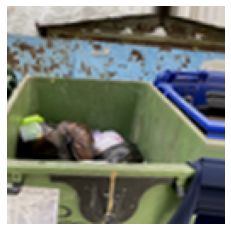

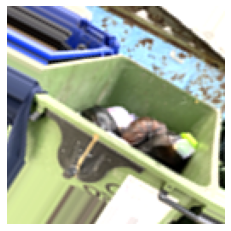

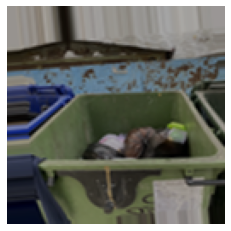

In [619]:
generated_images, generated_labels = augment(X_train[0], y_train[0], 10)

for i in range(3):
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.show()

In [620]:
augmented_images, augmented_labels = [], []

for i in range(len(X_train)):
    generated_images, generated_labels = augment(X_train[i], y_train[i], 10)
    augmented_images.extend(generated_images)
    augmented_labels.extend(generated_labels)

X_train, y_train = utils.shuffle(np.array(augmented_images), np.array(augmented_labels))

print('X_train shape:', X_train.shape, '\ny_train shape:', y_train.shape)

X_train shape: (5400, 128, 128, 3) 
y_train shape: (5400, 1)


In [621]:
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = y_train.astype('float32').reshape((-1,1))
y_test = y_test.astype('float32').reshape((-1,1))

# Building convolutional neural network

In [622]:
loss = SparseCategoricalCrossentropy(from_logits=True)
optimizer = 'Adam'
metrics = ['accuracy', f1]
epochs = 10

model = Sequential([
                    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    Dropout(0.75),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dropout(0.5),
                    Dense(16, activation='relu'),
                    Dense(2)
])

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

loss, accuracy, f1 = model.evaluate(X_test, y_test) 
print('\naccuracy:', round(accuracy, 2), '\nf1:', round(f1, 2))

Epoch 1/10
169/169 [==============================] - 150s 883ms/step - loss: 0.6200 - accuracy: 0.6343 - f1: 0.1711 - val_loss: 0.4820 - val_accuracy: 0.8074 - val_f1: 0.2150
Epoch 2/10
169/169 [==============================] - 148s 875ms/step - loss: 0.5310 - accuracy: 0.7226 - f1: 0.3778 - val_loss: 0.2474 - val_accuracy: 0.9185 - val_f1: 0.6948
Epoch 3/10
169/169 [==============================] - 148s 874ms/step - loss: 0.4080 - accuracy: 0.8211 - f1: 0.5278 - val_loss: 0.1938 - val_accuracy: 0.9259 - val_f1: 0.6093
Epoch 4/10
169/169 [==============================] - 147s 871ms/step - loss: 0.3181 - accuracy: 0.8669 - f1: 0.6345 - val_loss: 0.1676 - val_accuracy: 0.9481 - val_f1: 0.7582
Epoch 5/10
169/169 [==============================] - 148s 873ms/step - loss: 0.2701 - accuracy: 0.8969 - f1: 0.6654 - val_loss: 0.1313 - val_accuracy: 0.9778 - val_f1: 0.7212
Epoch 6/10
169/169 [==============================] - 147s 873ms/step - loss: 0.2208 - accuracy: 0.9143 - f1: 0.6767 - v